Predict the prices of house using multi-dimensional data
Used multiple models including linear regression, logistics regression, k neighbors regression, support vector regression, decision tree regression, etc.

In [1]:
import csv
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.special as sp
import numpy as np
import seaborn as sns
import sklearn
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.base import clone as clr_copy
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_absolute_error
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, LogisticRegression, BayesianRidge
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import json
import itertools
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
def logical_if(x1, x2):
    return np.logical_or(np.logical_not(x1), x2)
def kaggleize(predictions,file):

    if(len(predictions.shape)==1):
        predictions.shape = [predictions.shape[0],1]

    ids = 1 + np.arange(predictions.shape[0])[None].T
    kaggle_predictions = np.hstack((ids,predictions))
    writer = csv.writer(open(file, 'w', newline=''))
    if predictions.shape[1] == 1:
        writer.writerow(['Id','Predicted'])
    elif predictions.shape[1] == 2:
        writer.writerow(['Id','Predicted1', 'Predicted2'])
    for item in kaggle_predictions:
        writer.writerow([int(item[0]), item[1]])
#     writer.writerows(kaggle_predictions)

In [2]:
data:pd.DataFrame = pd.merge(pd.read_csv('Data/train_x.csv', header=None), pd.read_csv('Data/train_y.csv', header=None, names=['y']), left_index=True, right_index=True)
data = data.loc[:, (data != data.iloc[0]).any()]
data = data[data.columns.difference((220, 229, 176))]
Y = data['y']
X = data.drop(columns='y')
discribe = data.describe()
test_data = pd.read_csv('Data/test_x.csv', header=None)

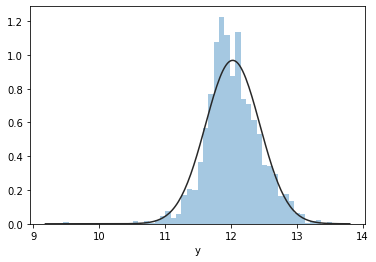

In [9]:
sns.distplot(np.log1p(data['y']), kde=False, fit=stats.norm)
plt.savefig('log y.png')
plt.show()

In [227]:
def discrete_columns(in_data):
    result = []
    for col in in_data.columns:
        if len(in_data[col].unique()) < 20:
            result.append(col)
    return np.array(result)

In [228]:
discrete_cols = discrete_columns(data)
continuous_cols = data.columns.difference(discrete_cols)
discrete_cols, continuous_cols, data.index

(array([  0,   3,   4,   5,   6,   7,   8,  12,  13,  14,  15,  16,  17,
         19,  23,  24,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  41,  42,  44,  45,  46,  52,  53,  54,  56,  57,  58,  59,
         60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,
         73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  85,  87,
         88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100,
        101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113,
        114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126,
        127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
        140, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 154,
        155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
        168, 169, 170, 172, 173, 174, 175, 177, 178, 179, 180, 182, 183,
        184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196,
        197, 198, 200, 201, 202, 203, 204, 205, 206

In [229]:
def plot_scatter(data, columns, drop_0_cols, nrows, ncols, size, file_path):
    f, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=size)
    for i, index in enumerate(columns):
        if index in drop_0_cols:
            data2 = data[[index, 'y']]
            data2 = data2.drop(data2[data2[index] == 0].index)
            sns.scatterplot(x=index, y='y', data=data2, ax=axes[int(i / ncols)][i % ncols])
        else:
            sns.scatterplot(x=index, y='y', data=data, ax=axes[int(i / ncols)][i % ncols])
        axes[int(i / ncols)][i % ncols].set_title(str(i))
    plt.savefig(file_path)
    print('ready')

In [230]:
outliers = data[(data[25] > 3500) & (data['y'] < 300000)].index
print(outliers)
outliers = outliers.append(data[data[1] > 250].index)
print(outliers)
outliers = outliers.append(data[data[2] > 100000].index)
outliers = outliers.append(data[(data[2] > 40000) & (data['y'] < 200000)].index)
outliers = outliers.append(data[data['y'] < 20000].index)
outliers = outliers.append(data[(data[43] > 1200) & (data['y'] < 100000)].index)
outliers = outliers.append(data[(data[48] > 400) & (data['y'] < 100000)].index)
outliers

Int64Index([1497, 1498], dtype='int64')
Int64Index([1497, 1498, 1265, 1498], dtype='int64')


Int64Index([1497, 1498, 1265, 1498,  956, 1570,  314, 1015, 1498, 1610, 1638,
             181, 1553, 1557,  726],
           dtype='int64')

ready


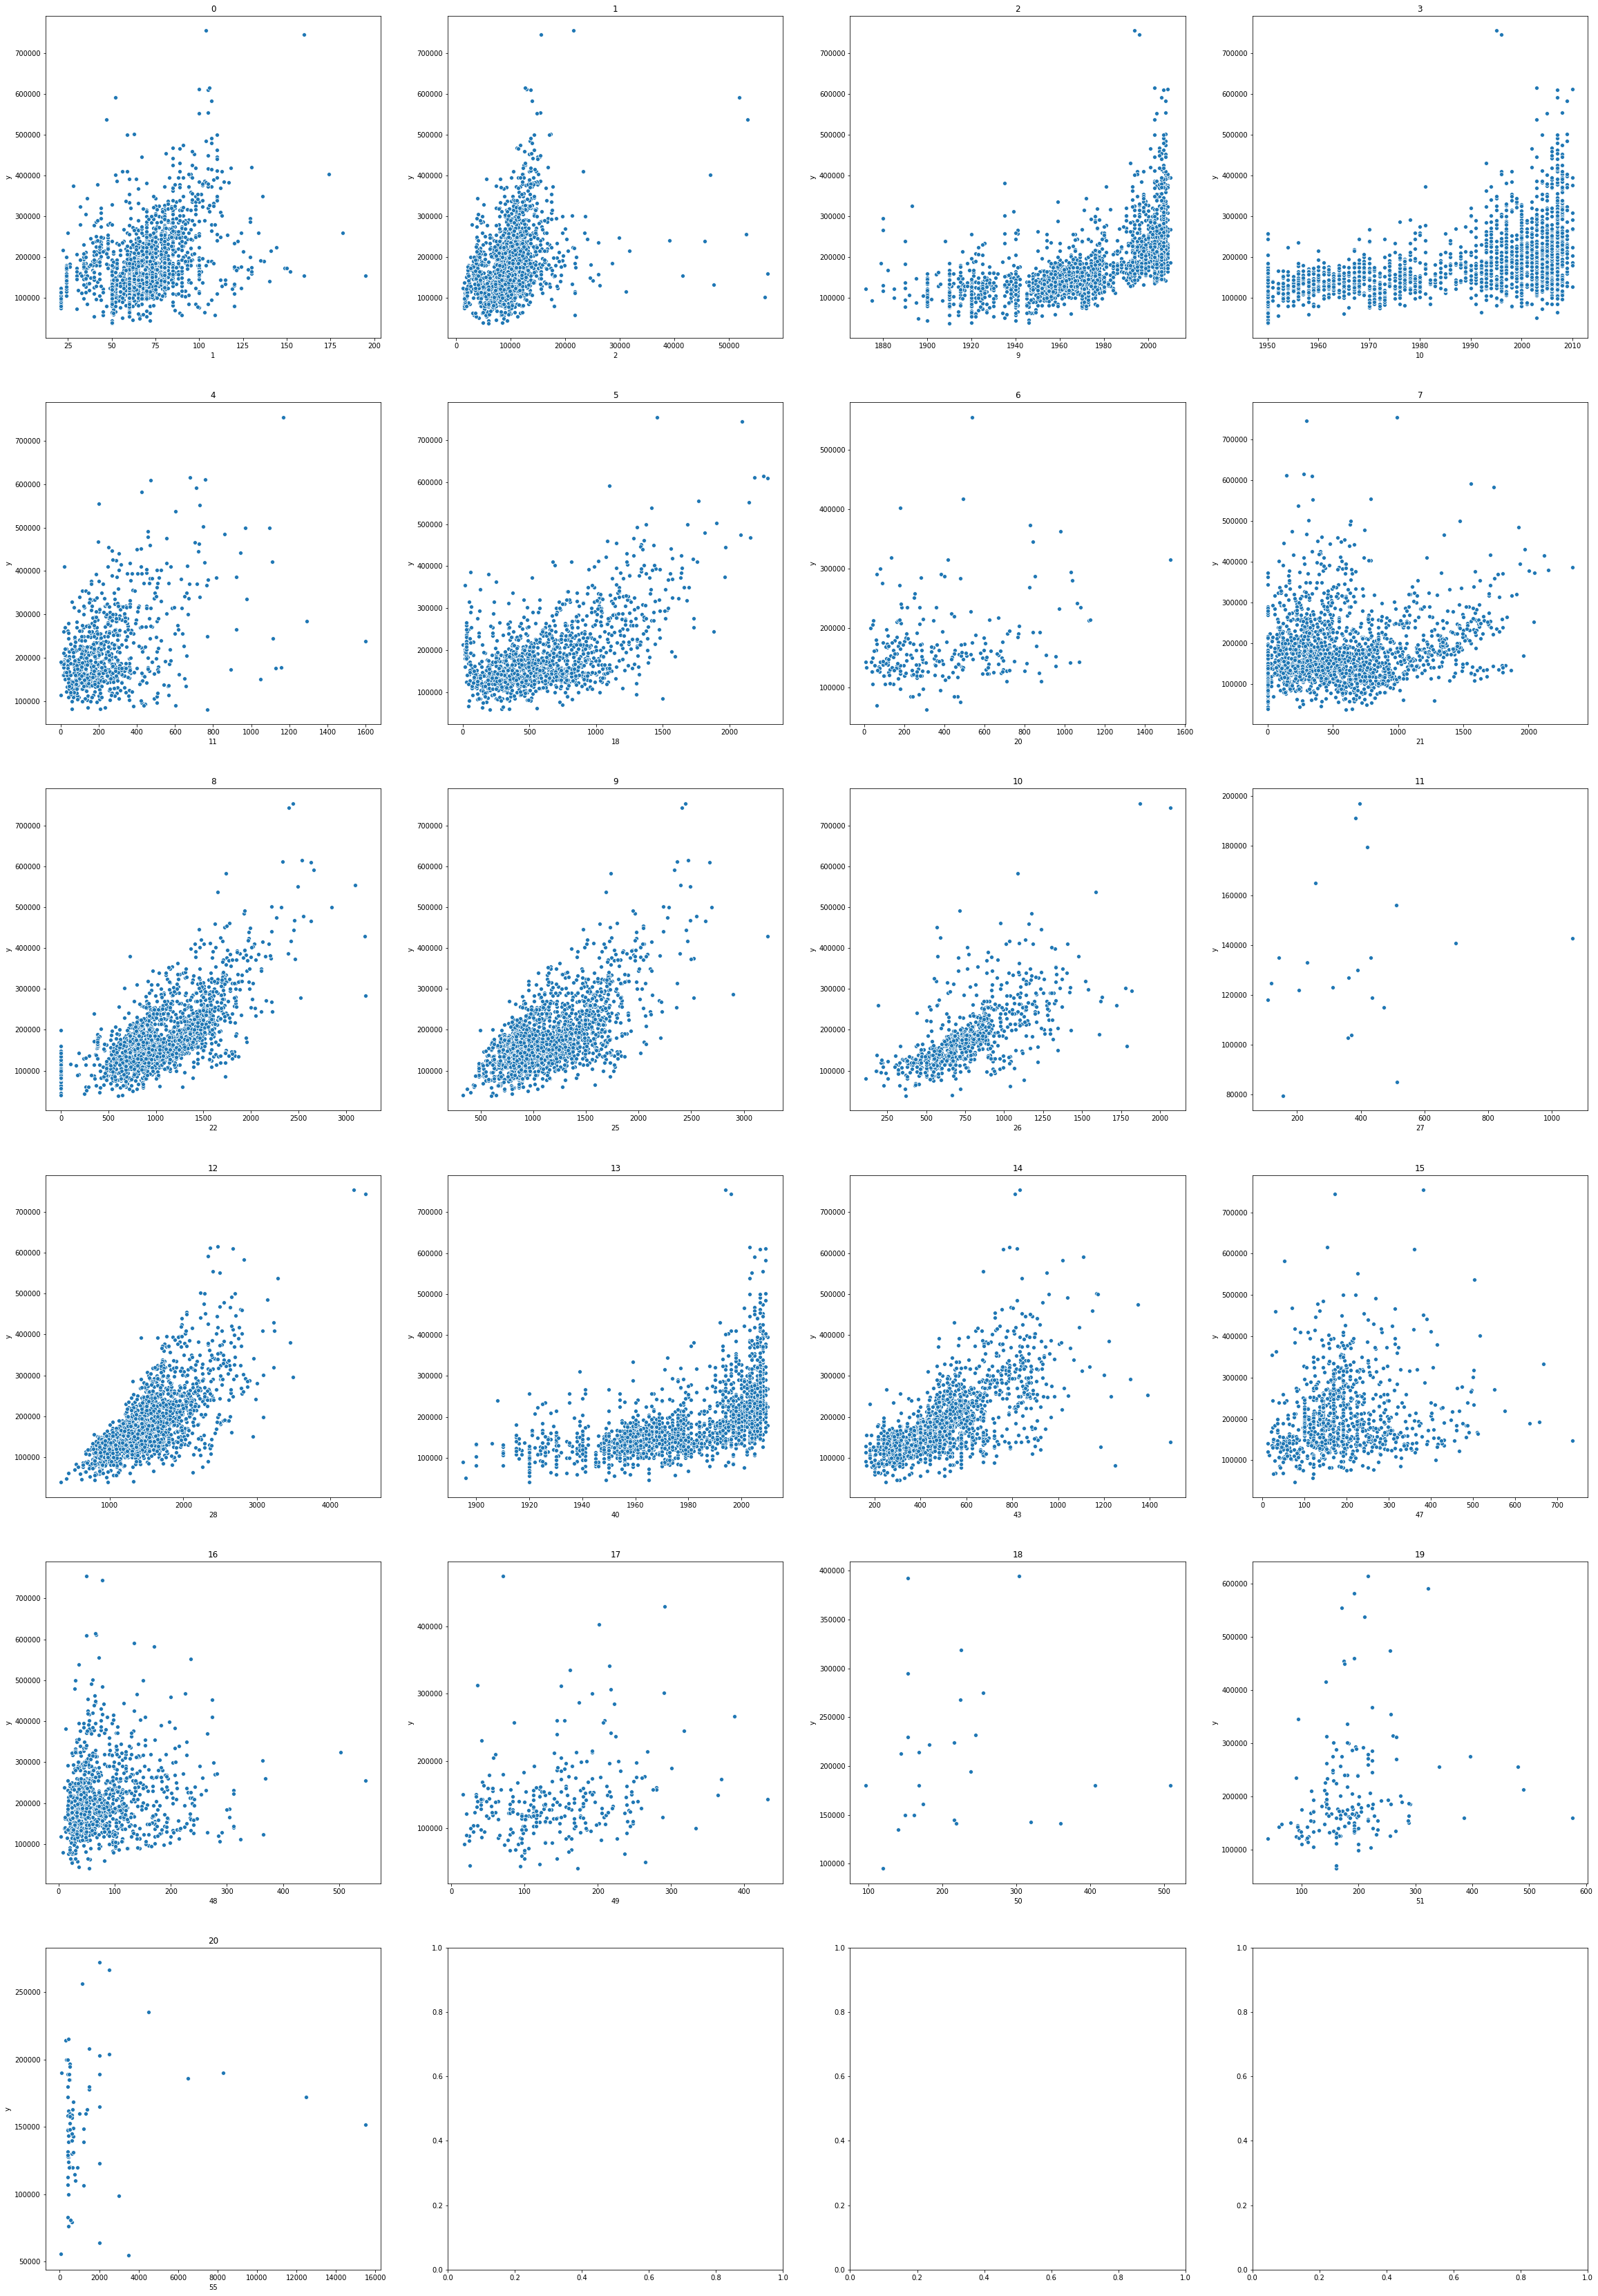

In [219]:
data = data.drop(data[(data[25] > 3500) & (data['y'] < 300000)].index)
data = data.drop(data[data[1] > 250].index)
data = data.drop(data[data[2] > 100000].index)
data = data.drop(data[(data[2] > 40000) & (data['y'] < 200000)].index)
data = data.drop(data[data['y'] < 20000].index)
data = data.drop(data[(data[43] > 1200) & (data['y'] < 100000)].index)
data = data.drop(data[(data[48] > 400) & (data['y'] < 100000)].index)
dp_zeros = (11, 18, 20, 26, 27, 40, 43, 47, 48, 49, 50, 51, 55)
plot_scatter(data, continuous_cols[:-1], dp_zeros,  6, 4, (40, 60), 'scatter 2.png')

In [159]:
data['y'] = np.log1p(data['y'])

In [160]:
data[continuous_cols] = data[continuous_cols].replace(0, np.nan)

In [211]:
temp_data = data[continuous_cols]
data2 = data.copy()
skews = temp_data.apply(lambda x: stats.skew(x.dropna()))
skews = skews[np.abs(skews) > 0.75]
for i in skews.index:
    data2[i] = sp.boxcox1p(data2[i], 0.15)
change = np.abs(data2[skews.index].skew()) - np.abs(skews)
print(change.index)

Index([2, 11, 20, 21, 22, 25, 26, 27, 28, 43, 47, 48, 50, 51, 55], dtype='object')


In [197]:
data2 = data2.fillna(data2.mean())

ready


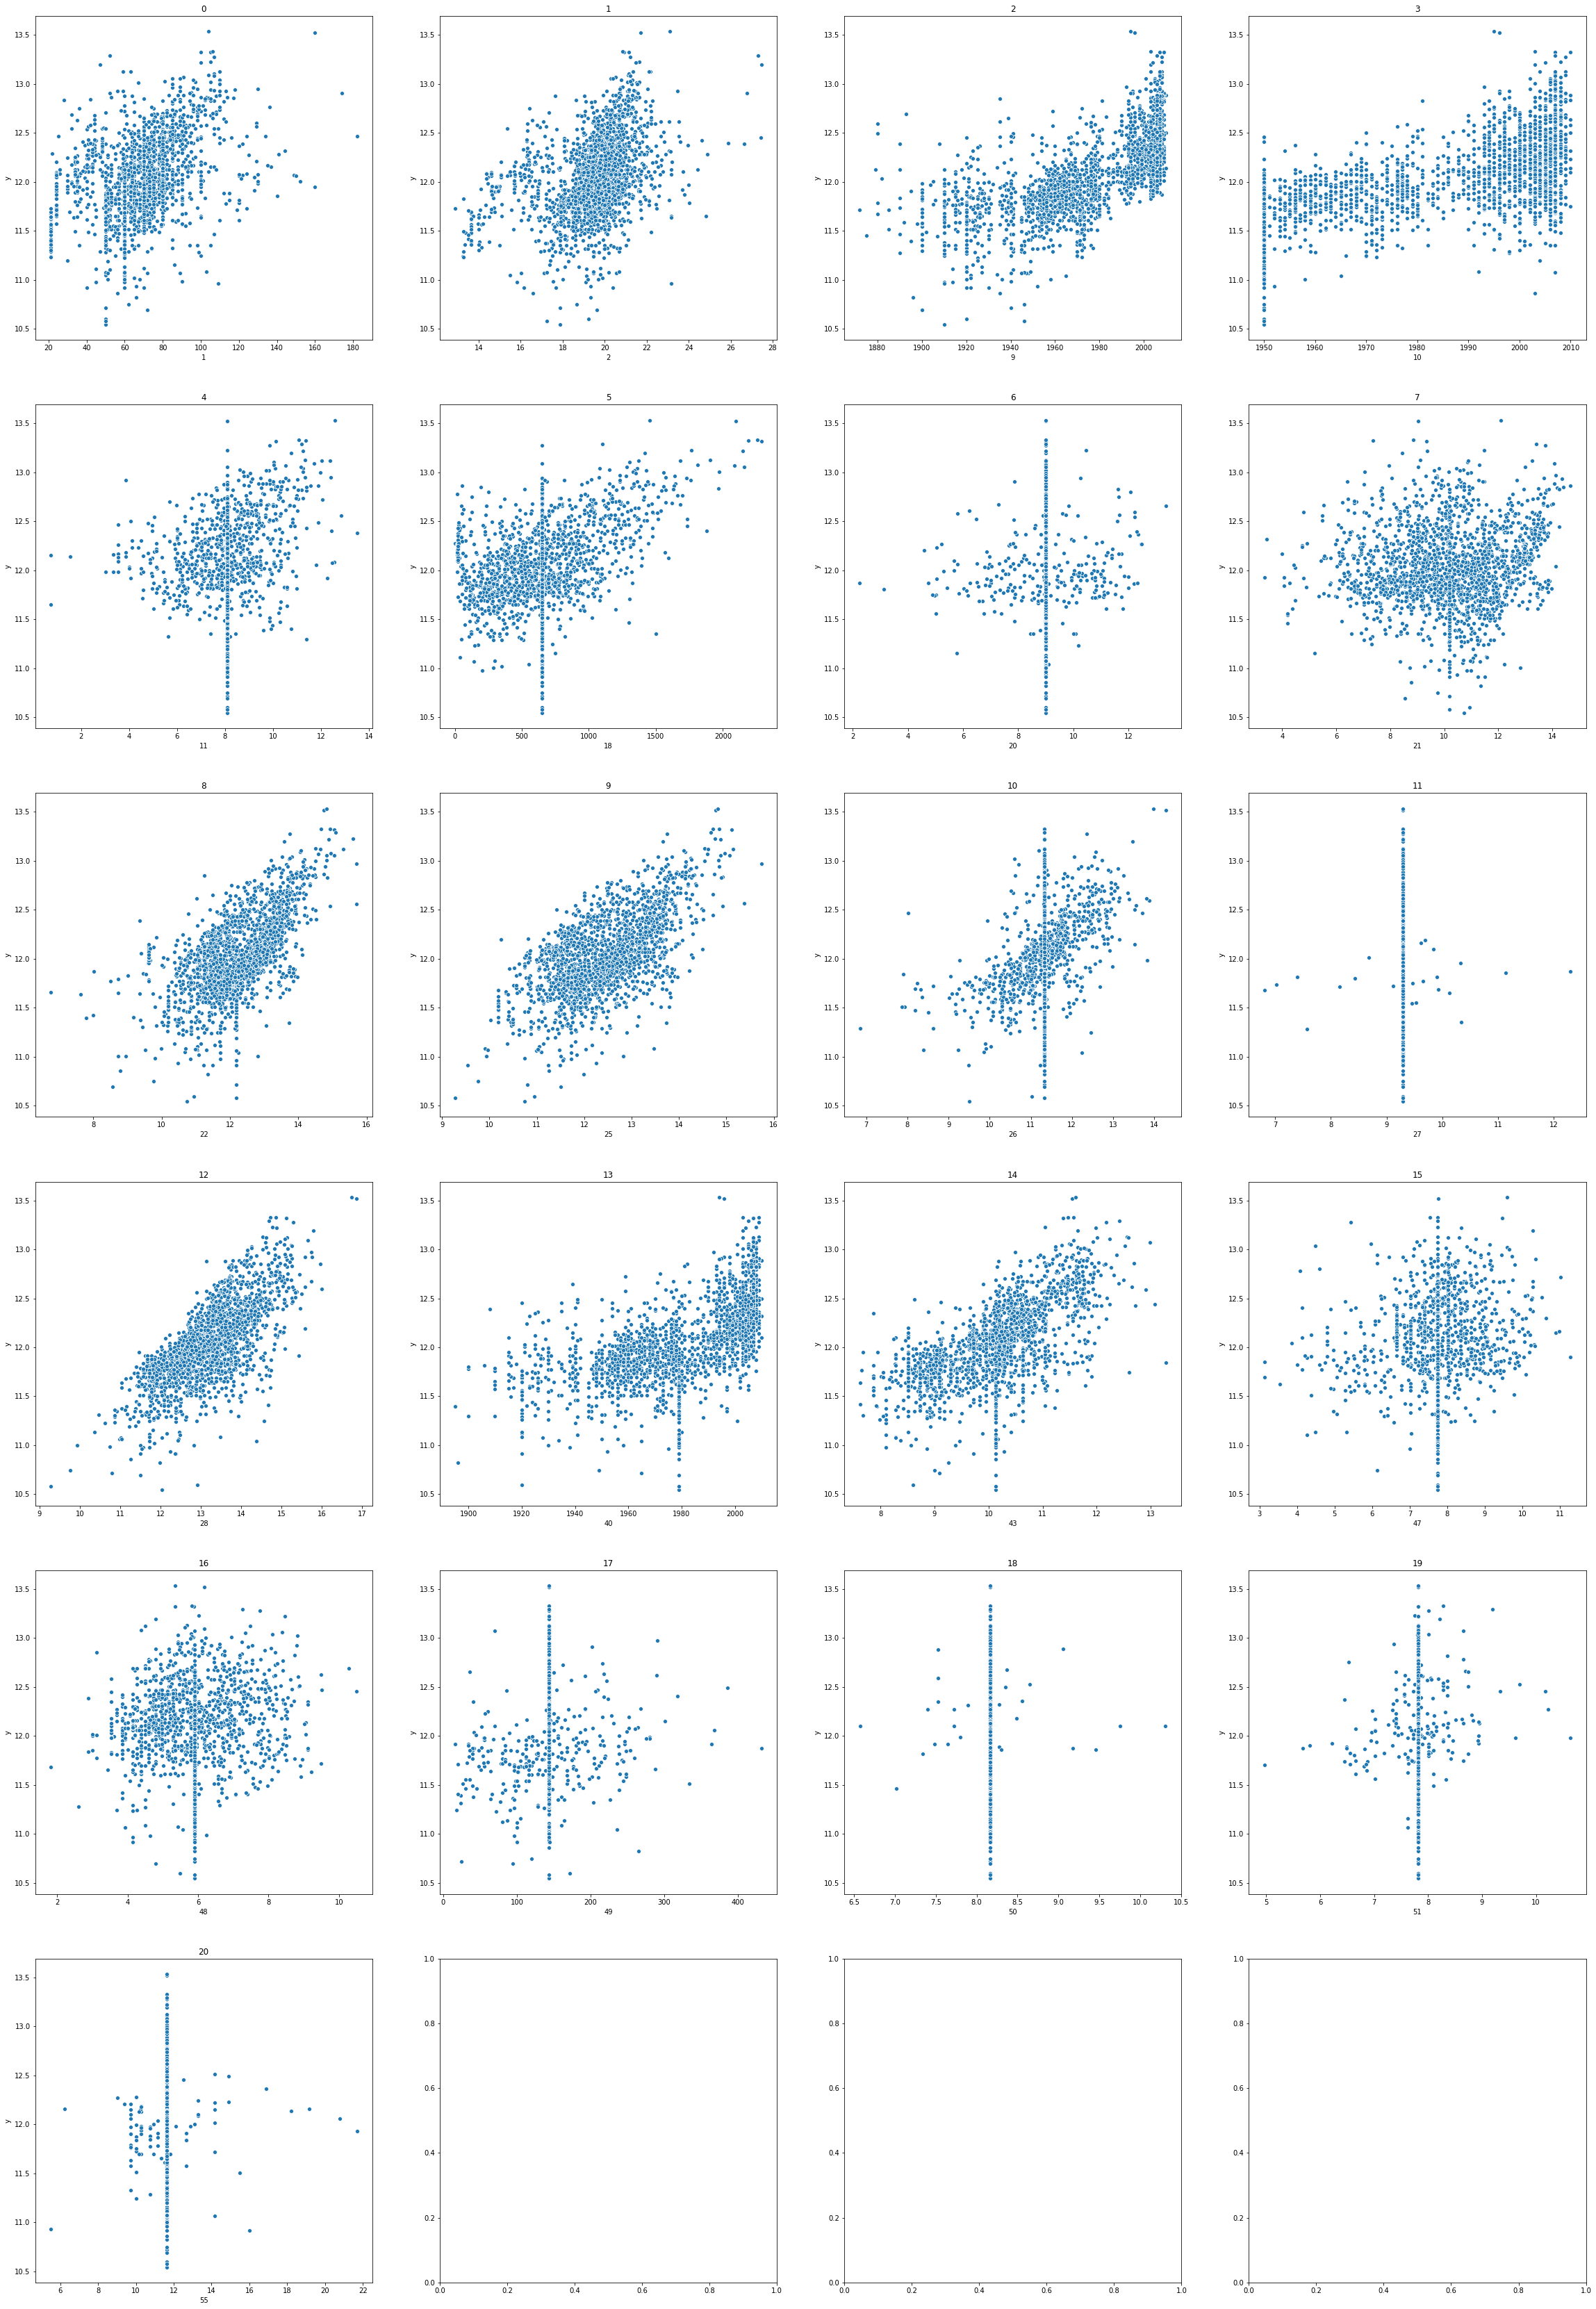

In [210]:
plot_scatter(data2, continuous_cols[:-1], dp_zeros,  6, 4, (40, 60), 'scatter 3.png')

In [201]:
missing_too_much_cont = []
for i in continuous_cols:
    zero_count = data[i].value_counts().iloc[0]
    if zero_count / len(data) > 0.75:
        missing_too_much_cont.append(i)
data = data.drop(columns=missing_too_much_cont)

In [280]:
handle_nan = (1, 11, 18, 22, 26, 40, 43, 47, 48)
for i in handle_nan:
    data[i] = data[i].replace(0, np.nan)

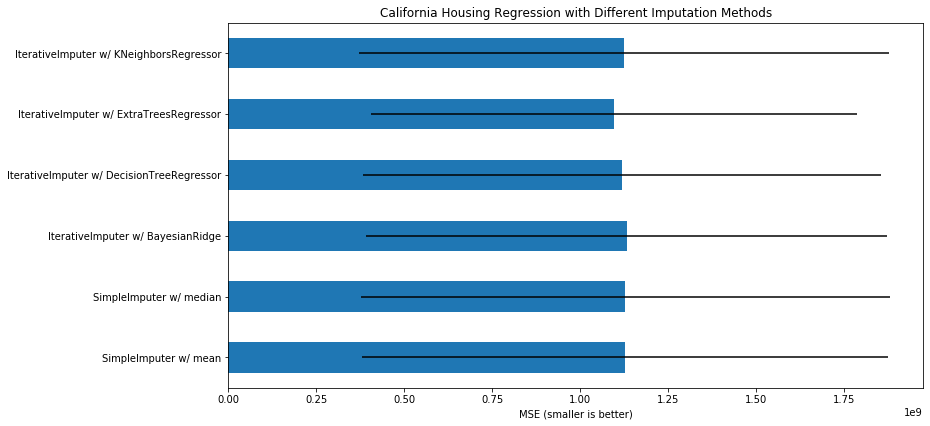

In [283]:
X = data.drop(columns='y')
y = data['y']
N_SPLITS = 5

for k, v in grid_params.items():
    clr = models[k]
    v = [{'model__' + k: value for k, value in param.items()} for param in v]
    print(k)
    grid_cv = GridSearchCV(clr, v, scoring='neg_mean_square_error', cv=5, verbose=1, n_jobs=-1)
    grid_cv.fit(X, y)
    best_grid[k] = grid_cv.best_estimator_
    scores_grid[k] = -cross_val_score(best_grid[k], x_out, y_out, scoring='neg_mean_square_error', cv=kfolds)

In [ ]:
impute_models = {
    'svr': Pipeline(steps=[('scaler', RobustScaler()), ('model', SVR())]),
    'lr': Pipeline(steps=[('scaler', RobustScaler()), ('model', LinearRegression(normalize=True))]),
    'lgr': Pipeline(steps=[('scaler', RobustScaler()), ('model', LogisticRegression())]),
    'knr': Pipeline(steps=[('scaler', RobustScaler()), ('model', KNeighborsRegressor())]),
    'dtr': Pipeline(steps=[('scaler', RobustScaler()), ('model', DecisionTreeRegressor())])
}

In [6]:
corr_mat = data.corr()
corr_threshold = 0.2
corr = corr_mat.loc[corr_mat['y'] > corr_threshold, corr_mat.loc['y'] > corr_threshold]
data = data[corr.columns]

In [18]:
def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, 'y']].groupby(feature).mean()['y']
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, str(feature)+'_E'] = o
    
qual_encoded = []
for q in discrete_cols:  
    encode(data, q)
    qual_encoded.append(str(q)+'_E')
print(qual_encoded)

['7_E', '24_E', '29_E', '31_E', '32_E', '36_E', '38_E', '42_E', '44_E', '45_E', '46_E', '63_E', '92_E', '93_E', '135_E', '159_E', '176_E', '180_E', '183_E', '186_E', '200_E', '202_E', '220_E', '229_E', '236_E']


In [24]:
def spearman(frame, features):
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame['y'], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')
    
features = list(continuous_cols) + qual_encoded

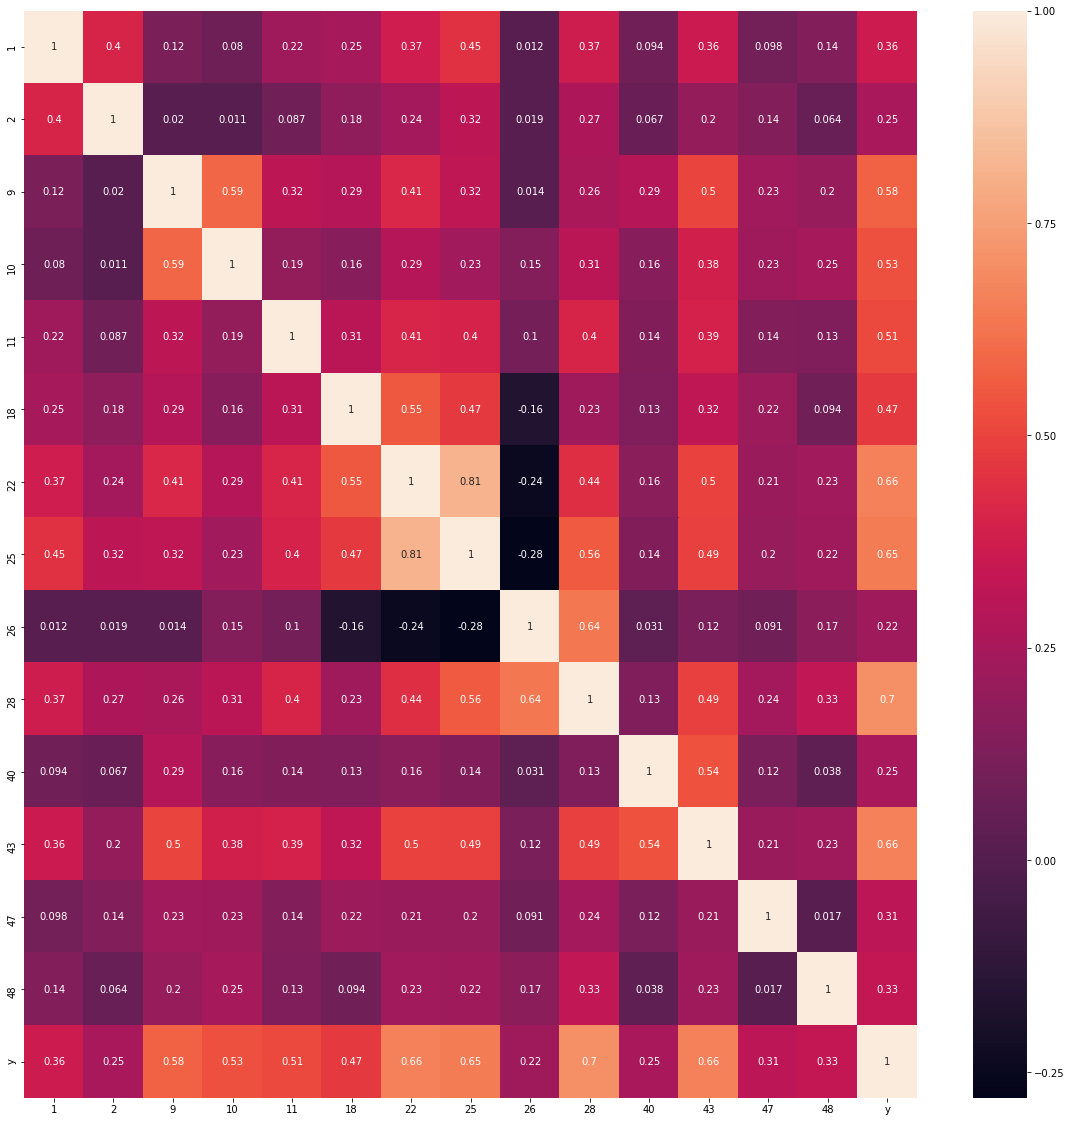

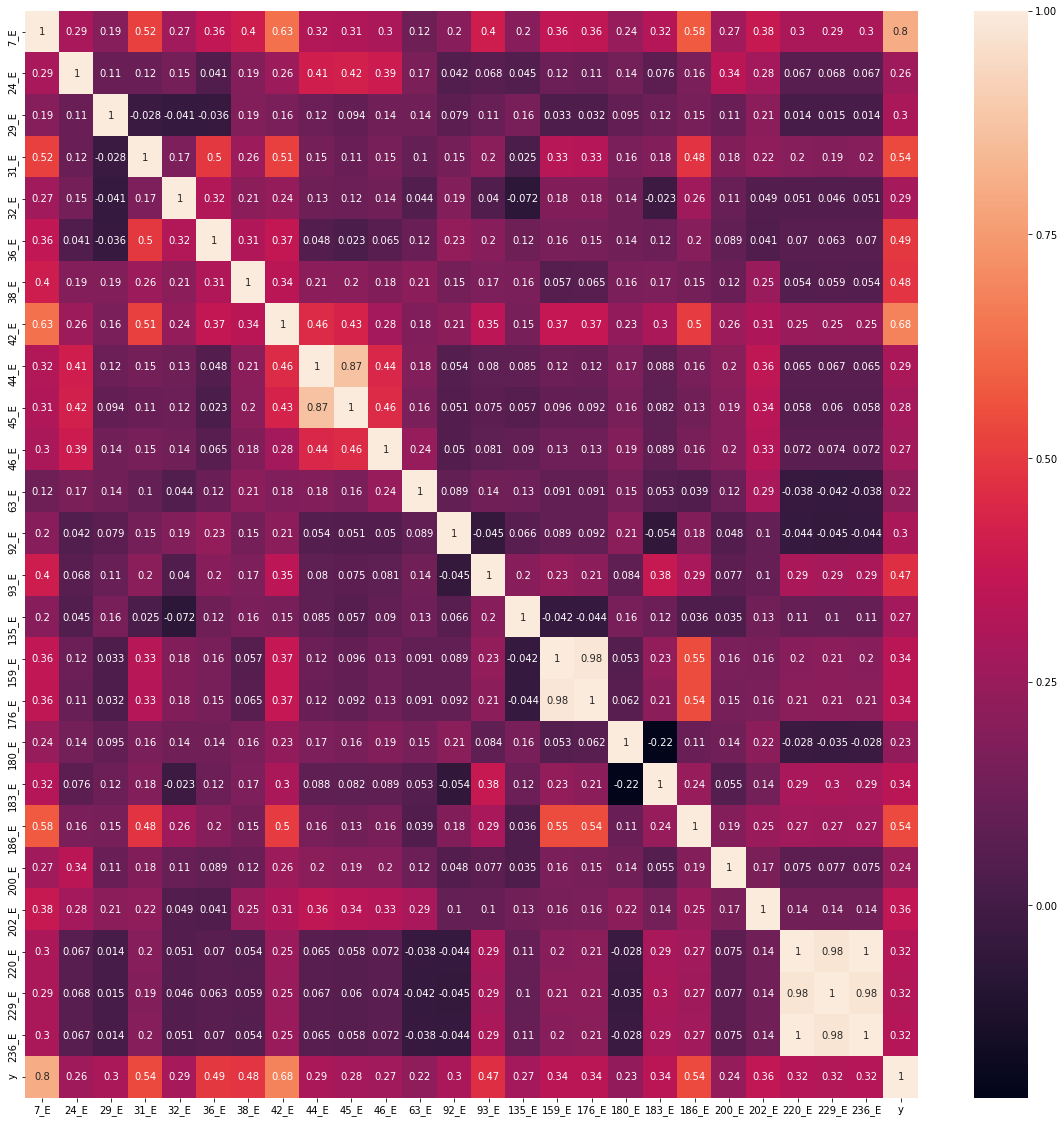

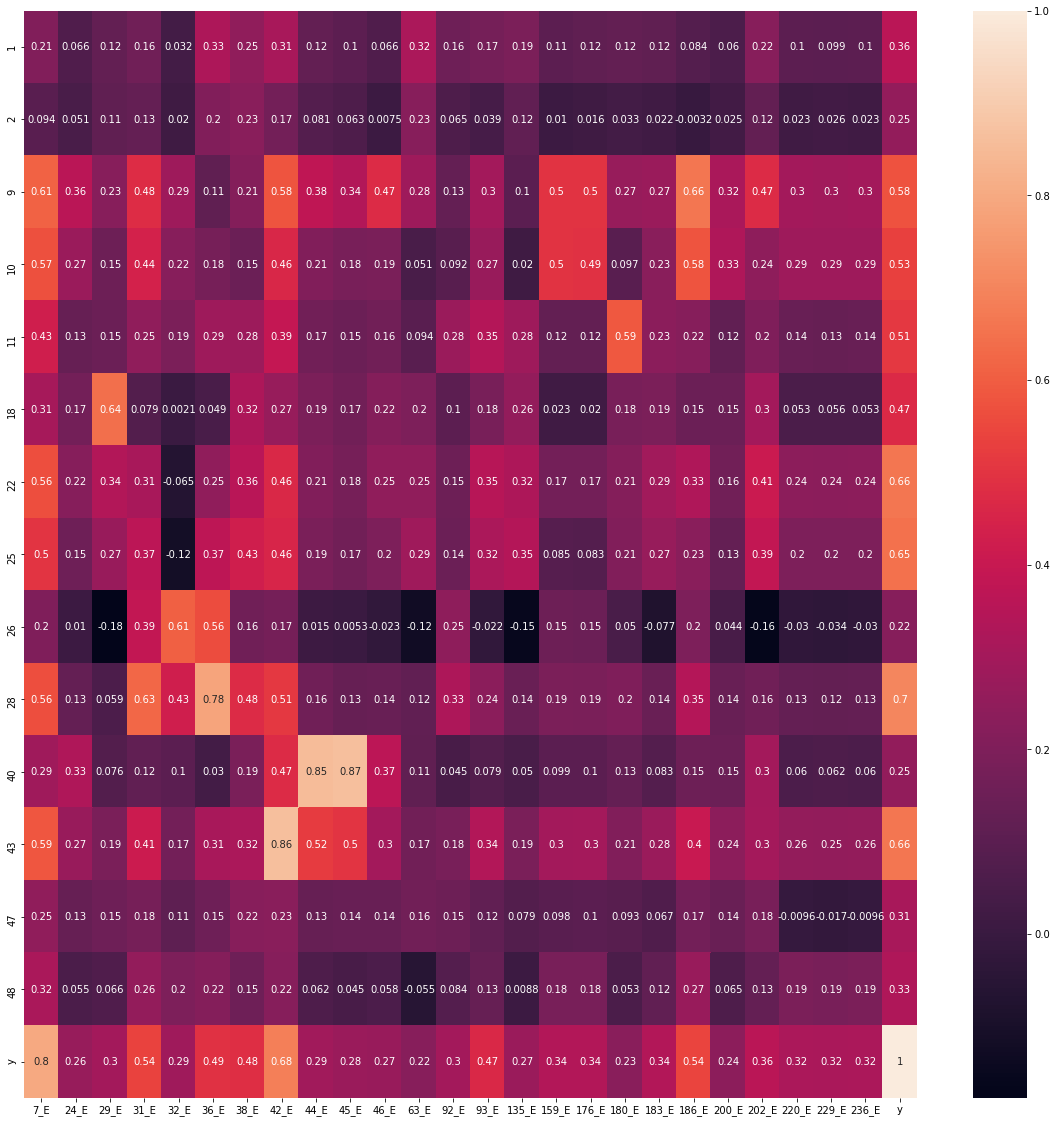

In [34]:
plt.figure(1, figsize=(20, 20))
corr = data[list(continuous_cols)].corr()
sns.heatmap(corr, annot=True)
plt.figure(2, figsize=(20, 20))
corr = data[qual_encoded+['y']].corr()
sns.heatmap(corr, annot=True)
plt.figure(3, figsize=(20, 20))
corr = pd.DataFrame(np.zeros([len(continuous_cols), len(qual_encoded)+1]), index=list(continuous_cols), columns=qual_encoded+['y'])
for q1 in list(continuous_cols):
    for q2 in qual_encoded+['y']:
        corr.loc[q1, q2] = data[q1].corr(data[q2])
sns.heatmap(corr, annot=True)

In [92]:
data2 = data[(x for x in data.columns if not (isinstance(x, str) and x[-1] == 'E'))]
print(len(data2.columns))
data2.columns

40


Index([  1,   2,   7,   9,  10,  11,  18,  22,  24,  25,  26,  28,  29,  31,
        32,  36,  38,  40,  42,  43,  44,  45,  46,  47,  48,  63,  92,  93,
       135, 159, 176, 180, 183, 186, 200, 202, 220, 229, 236, 'y'],
      dtype='object')

In [87]:
data2['y'] = np.log1p(data2['y'])

In [97]:
X = data2.drop(columns='y')
Y = data2['y'].reset_index(drop=True)
features = pd.concat([X, test_data[X.columns]]).reset_index(drop=True)
print(len(features.columns))
features.columns

39


Index([  1,   2,   7,   9,  10,  11,  18,  22,  24,  25,  26,  28,  29,  31,
        32,  36,  38,  40,  42,  43,  44,  45,  46,  47,  48,  63,  92,  93,
       135, 159, 176, 180, 183, 186, 200, 202, 220, 229, 236],
      dtype='object')

In [99]:
skews_features = features.apply(lambda x: stats.skew(x)).sort_values(ascending=False)
high_skews_features = skews_features[skews_features > 0.5]
transed_skews_features = features
for i in high_skews_features.index:
    before = transed_skews_features[i].skew()
    transed_skews_features[i] = sp.boxcox1p(transed_skews_features[i], stats.boxcox_normmax(transed_skews_features[i] + 1))
    print(before, transed_skews_features[i].skew())

12.896952443392276 -0.1427539375702427
6.157059340345023 6.157059340345022
3.813874919552137 3.813874919552136
3.06372863821161 3.0637286382116105
3.06372863821161 3.0637286382116105
3.013953059434214 3.0139530594342125
2.965832285662124 2.9658322856621235
2.615734731630823 0.9761718322508
2.5373402659866153 0.6195112544679121
1.8317480225301743 0.7846265401947046
1.592714173013223 1.5927141730132224
1.4886993209999317 -0.011136571121910506
1.4328662210960348 0.376721383490592
1.2770134544398883 0.005528354452627364
1.1652807810932362 0.37470197401290706
0.867953658553494 0.8679536585534943
0.8610169666191466 0.8947663590766191
0.7608340523255753 0.046922721190654146
0.736036702754814 0.5509269448734824
0.6957438084861001 0.7317144412599812
0.6420493418435341 0.6420493418435347
0.6229461434571659 0.6229461434571661
0.6180503679810353 0.6129126234705528


In [102]:
X = features.iloc[:len(Y), :]
X.shape, Y.shape

((2000, 39), (2000,))

In [108]:
def get_outliers(in_data, index, threshold=0.25):
    ql, qh = in_data[index].quantile(threshold), in_data[index].quantile(1 - threshold)
    iqr = qh - ql
    lo, hi = ql - 1.5 * iqr, qh + 1.5 * iqr
    return in_data[(in_data[index] < lo) | (in_data[index] > hi)].index


In [133]:
x_out, y_out = X, Y
outliers = set()
for index in X.columns:
    outlier = get_outliers(x_out, index)
    if len(outlier) > 100:
        outlier = get_outliers(x_out, index, 0.1)
    outliers = outliers.union(set(outlier))
x_out = x_out.drop(index = outliers)
y_out = y_out.drop(index = outliers)
x_out.shape, y_out.shape

((1174, 39), (1174,))

In [138]:
overfit = set()
for i in x_out.columns:
    counts = x_out[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(x_out) * 100 > 99.94:
        overfit.add(i)
x_out = x_out.drop(overfit, axis=1)

In [142]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

In [284]:
models = {
    'svr': Pipeline(steps=[('scaler', RobustScaler()), ('model', SVR())]),
    'lr': Pipeline(steps=[('scaler', RobustScaler()), ('model', LinearRegression(normalize=True))]),
    'lgr': Pipeline(steps=[('scaler', RobustScaler()), ('model', LogisticRegression())]),
    'knr': Pipeline(steps=[('scaler', RobustScaler()), ('model', KNeighborsRegressor())]),
    'dtr': Pipeline(steps=[('scaler', RobustScaler()), ('model', DecisionTreeRegressor())])
}

In [185]:
scores = {}
for name, clr in models.items():
    score = -cross_val_score(clr, x_out, y_out, scoring='neg_mean_absolute_error', cv=kfolds)
    scores[name] = score
print(scores)


{'svr': array([37977.85532591, 32426.45040486, 35451.79550057, 36868.54071697,
       35082.37626845, 36463.29586821, 41098.35132528, 38294.16157708,
       37465.93699241, 36202.21472292]), 'lr': array([15726.09875364, 12686.38754696, 13677.72583126, 15753.84659517,
       13974.45715847, 17032.61287903, 13731.96694069, 14963.55460876,
       14076.10597051, 13137.91984413]), 'lgr': array([24542.79661017, 20412.5       , 18505.50847458, 25270.12711864,
       23078.94017094, 23200.64102564, 23289.25641026, 23139.33333333,
       25878.64102564, 22776.5042735 ]), 'knr': array([17345.64237288, 13272.74576271, 15299.61694915, 17418.79152542,
       15180.18974359, 15422.27692308, 16426.62735043, 15448.93333333,
       15102.82564103, 17220.49230769]), 'dtr': array([19383.74576271, 22182.42372881, 17401.94915254, 18203.3220339 ,
       20386.30769231, 22041.51282051, 19493.2991453 , 18128.90598291,
       20825.69230769, 15631.11111111])}


In [186]:
print({k: np.mean(v) for k, v in scores.items()})

{'svr': 36733.09787026646, 'lr': 14476.067612863762, 'lgr': 23009.42484427061, 'knr': 15813.814190931478, 'dtr': 19367.826973779516}


In [285]:
grid_params = {
    'svr':[
        {
            'C': list(np.logspace(-2, 3, 6)), 
            'kernel': ['rbf', 'sigmoid', 'linear'], 
            'gamma': list(np.logspace(-5, 2, 8))
        }
    ],
    'lr': [{}],
    'lgr': [
        {
            'penalty': ['l1'], 
             'C': list(np.logspace(-3, 3, 7)),
             'solver': ['liblinear', 'saga']
        }, {
            'penalty': ['l2'],
             'C': list(np.logspace(-3, 3, 7)),
             'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']
        }, {
            'penalty': ['elasticnet'],
            'l1_ratio': list(np.logspace(-3, -1, 5)),
             'C': list(np.logspace(-3, 3, 7)),
             'solver': ['saga']
        }
    ],
    'knr': [
        {
            'n_neighbors': list(range(2,5,1)), 
            'weights':['uniform', 'distance'], 
            'p':[1,2,3]
        }
    ],
    'dtr': [
        {
            'criterion': ['mse', 'mae', 'friedman_mse'], 
            'max_features': ['sqrt', 'log2', 'auto'],
            'max_depth': list(range(2, 8)), 
            'min_samples_leaf': list(range(5, 7))
        }
    ]
}

In [209]:
scores_grid = {}
best_grid = {}

In [210]:
for k, v in grid_params.items():
    clr = models[k]
    v = [{'model__' + k: value for k, value in param.items()} for param in v]
    print(k)
    grid_cv = GridSearchCV(clr, v, scoring='neg_mean_absolute_error', cv=kfolds, verbose=1, n_jobs=-1)
    grid_cv.fit(x_out, y_out)
    best_grid[k] = grid_cv.best_estimator_
    scores_grid[k] = -cross_val_score(best_grid[k], x_out, y_out, scoring='neg_mean_absolute_error', cv=kfolds)
print(scores_grid)

svr
Fitting 10 folds for each of 144 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 828 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   13.2s finished


lr
Fitting 10 folds for each of 1 candidates, totalling 10 fits
lgr

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



Fitting 10 folds for each of 77 candidates, totalling 770 fits


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 463 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done 770 out of 770 | elapsed: 29.7min finished


knr
Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


dtr
Fitting 10 folds for each of 108 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.3s


{'svr': array([15005.51299374, 11701.46788313, 13110.98957595, 15698.58767587,
       13643.02554245, 16383.81592457, 13541.14797003, 14309.67084802,
       14135.97566108, 13334.89902345]), 'lr': array([15726.09875364, 12686.38754696, 13677.72583126, 15753.84659517,
       13974.45715847, 17032.61287903, 13731.96694069, 14963.55460876,
       14076.10597051, 13137.91984413]), 'lgr': array([19647.45762712, 20124.36440678, 19402.88135593, 24772.66949153,
       20072.95726496, 22376.70940171, 19447.54700855, 22247.88034188,
       23797.44444444, 21200.43589744]), 'knr': array([15780.48648221, 14121.88390897, 14026.94743152, 16236.78932668,
       15664.64916388, 15069.99613433, 16165.23118111, 15312.235261  ,
       15028.87001271, 15542.68439298]), 'dtr': array([19679.48593034, 17859.89620865, 18284.40080703, 16747.55339065,
       17984.91677972, 17942.28608257, 16001.45796886, 17696.84357877,
       15997.76579221, 15913.98851031])}


[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:    3.2s finished


In [211]:
{k: np.mean(v) for k, v in scores_grid.items()}

{'svr': 14086.509309827592,
 'lr': 14476.067612863762,
 'lgr': 21309.03472403303,
 'knr': 15294.977329540407,
 'dtr': 17410.859504911008}

In [241]:
test_x = features.iloc[len(Y):, :][x_out.columns].fillna(0)

In [244]:
y_pred = best_grid['svr'].predict(test_x)

In [247]:
kaggleize(y_pred, 'predict.csv')

In [349]:
y_pred2 = best_grid['lgr'].fit(x_out, y_out).predict(test_x)
kaggleize(y_pred2, 'predict.csv')